In [225]:
from flask import json
import joblib
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [226]:
GRADE_COLS = [
    "A+", "A", "A-", "B+", "B", "B-", "C+", "C", "C-", "D+", "D", "D-", "F", # values contributing to GPA
    "CR", "P", "NC", "NF", "NP", "I", "W" # grade columns that don't contribute to GPA, these will be treated as separate indicators
]

# we'll map the GPA only for actual letter grades
LETTER_GPA = {"A+": 4.0, "A": 4.0, "A-": 3.7, "B+": 3.3, "B": 3.0, "B-": 2.7, "C+": 2.3, "C": 2.0, "C-": 1.7, "D+": 1.3, "D": 1.0, "D-": 0.7, "F": 0.0}

# special cases will be handled separately rather than converted to placeholder GPA values (i.e. NC or W = 0, P = 4.0, etc)
SPECIAL_GRADES = {
    "W": "withdraw",
    "I": "incomplete",
    "CR": "credit",
    "P": "pass",
    "NC": "no_credit",
    "NF": "no_credit",
    "NP": "no_credit"
}

In [227]:
# load the professor data
def load_professor_dataset():
    professor_path = os.path.join("data", "matched_professor_data.json")
    try:
        with open(professor_path, "r", encoding="utf-8") as file:
            print(f"Loading professor dataset {professor_path}")
            prof_dict = json.load(file)
    except Exception as e:
        print(f"Error loading professor dataset {professor_path}: {e}")
        raise

    # instructor_id is the key from the json dataset, i.e. jxc064000
    df = pd.DataFrame.from_dict(prof_dict, orient="index")
    df.index.name = "instructor_id"
    df.reset_index(inplace=True)

    # smooth out any formatting inconsistencies
    df["instructor_id"] = df["instructor_id"].astype(str).str.strip()

    expected_defaults = {
        "quality_rating": np.nan,
        "difficulty_rating": np.nan,
        "would_take_again": np.nan,
        "ratings_count": 0,
        "tags": [],
        "url": None,
    }

    for col, default in expected_defaults.items():
        if col not in df.columns:
            df[col] = default

        # special handling for tags (list field)
        if col == "tags":
            df[col] = df[col].apply(lambda x: x if isinstance(x, list) else default)
        else:
            # everything other var type
            df[col] = df[col].apply(lambda x: x if pd.notna(x) else default)


    # TF-IDF will need space-separated strings so we aggregate tags list into single string and flag if the data didn't have a matched RMP profile
    df["tags_text"] = df["tags"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")
    
    # in the RMP dataset, a 0 for quality rating or difficulty rating or a -1 for would take again indicates no responses, so these values should be filtered

    if "quality_rating" in df.columns:
        df["quality_rating"] = df["quality_rating"].apply(lambda x: np.nan if (pd.isna(x) or x <= 0) else x)
    
    if "difficulty_rating" in df.columns:
        df["difficulty_rating"] = df["difficulty_rating"].apply(lambda x: np.nan if (pd.isna(x) or x <= 0) else x)
    
    df["has_rmp"] = df["quality_rating"].notnull()

    # we also need to normalize would take again to 0-1 scale
    if "would_take_again" in df.columns:
        df["would_take_again_norm"] = df["would_take_again"].apply(lambda x: np.nan if (pd.isna(x) or x < 0) else x / 100.0)
    else:
        df["would_take_again_norm"] = np.nan


    # determine the quality of the resulting dataset
    total = len(df)
    valid_quality = df["quality_rating"].notna().sum()
    valid_difficulty = df["difficulty_rating"].notna().sum()
    valid_wta = df["would_take_again_norm"].notna().sum()
    
    print(f"\nRMP Data Quality:")
    print(f"Total professors: {total}")
    print(f"Valid quality ratings: {valid_quality} ({valid_quality/total*100:.1f}%)")
    print(f"Valid difficulty ratings: {valid_difficulty} ({valid_difficulty/total*100:.1f}%)")
    print(f"Valid would_take_again: {valid_wta} ({valid_wta/total*100:.1f}%)")

    return df

In [228]:
# load the grade data, used for extra insights (aggregated values use placeholders for withdrawal for example)
def load_all_grade_data():
    all_grades = []

    # iterate over the grades files in /data
    for filename in os.listdir("data"):
        if filename.startswith("enhanced_grades_") and filename.endswith(".csv"):
            grades_path = os.path.join("data", filename)
            print(f"Loading grades file {grades_path}")
            df = pd.read_csv(grades_path)
            
            # extract semester and year from filename for temporal analysis
            # helps with comparing data over time and throughout events like covid
            parts = filename.replace("enhanced_grades_", "").replace(".csv", "")
            if len(parts) >= 3:
                year_suffix = parts[:-1]  # e.g., "21"
                semester_code = parts[-1]  # e.g., "f"
                
                year = 2000 + int(year_suffix)
                
                semester_map = {"f": ("fall", 3), "s": ("spring", 1), "u": ("summer", 2)}
                semester_name, semester_num = semester_map.get(semester_code, ("unknown", 0))
                
                df["year"] = year
                df["semester"] = semester_name
                df["semester_num"] = semester_num
                # Create a sortable semester index (year * 10 + semester_num)
                df["semester_index"] = year * 10 + semester_num
            
            all_grades.append(df)

    if not all_grades:
        raise ValueError("No enhanced_grades_*.csv files found in /data directory.")

    # aggregate all grades into one df
    grades_df = pd.concat(all_grades, ignore_index=True)
    
    # normalize instructor id format so that missing ids are empty strings and no leading/trailing whitespace for easy removal
    grades_df["instructor_id"] = (grades_df["instructor_id"].fillna("").astype(str).str.strip().replace({"nan": "", "None": "", "": ""}))

    # remove records with empty instructor_id, sometimes occurs because student professors or TAs without ids are listed on courses
    before = len(grades_df)
    grades_df = grades_df[grades_df["instructor_id"] != ""] # only keep records with instructor ids
    after = len(grades_df)
    print(f"Grade data before removing empty instructor ids: {before}, after: {after}")

    if before != after:
        print(f"Removed {before - after} records with empty instructor ids")

    return grades_df

In [229]:
def engineer_tag_features(df):
    # define tag categories based on semantic meaning
    quality_keywords = ['caring', 'amazing', 'hilarious', 'inspirational', 'feedback', 'accessible', 'respected', 'clear']
    
    difficulty_keywords = ['tough', 'homework', 'test heavy', 'read', 'skip class', 'graded', 'papers', 'lots']
    
    engagement_keywords = ['extra credit', 'participation', 'group', 'lecture']
    
    def count_keywords(text, keywords):
        if not text or not isinstance(text, str):
            return 0
        text_lower = text.lower()
        return sum(1 for k in keywords if k in text_lower)
    
    df['quality_tag_count'] = df['tags_text'].apply(lambda x: count_keywords(x, quality_keywords))
    df['difficulty_tag_count'] = df['tags_text'].apply(lambda x: count_keywords(x, difficulty_keywords))
    df['engagement_tag_count'] = df['tags_text'].apply(lambda x: count_keywords(x, engagement_keywords))
    
    # compute total tags to differentiate memorable vs forgettable professor
    df['total_tag_count'] = (
        df['quality_tag_count'] + 
        df['difficulty_tag_count'] + 
        df['engagement_tag_count']
    )
    
    # more tags = more memorable/extreme professor
    df['tag_density'] = df['tags_text'].str.split().str.len().fillna(0)
    
    # reliability of ratings using log scale, more ratings = more reliable
    df['ratings_log'] = np.log1p(df['ratings_count'].fillna(0))
    
    return df

In [230]:
# not every grade distribution has the same columns, especially covid-era ones so we need to ensure all expected grade columns exist by filling missing ones with 0s
def check_grade_columns(df):
    for c in GRADE_COLS:
        if c not in df.columns:
            print(f"Column {c} not found, adding with default 0s") # it seems there is some variability in the grade columns between semesters so i used this to detect the ones i was missing
            df[c] = 0
    return df

# we compute mean gpa, percentage of letter grades, percentage of withdrawals, incompletes, dfw rate, and enrollment
def engineer_grade_features(df):
    df = check_grade_columns(df) # make sure all expected grade columns exist

    df["enrollment"] = df[GRADE_COLS].sum(axis=1)
    total = df["enrollment"].replace(0, np.nan)  # avoid div-by-zero

    print("Calculating GPA and grade percentages")
    df["gpa_sum"] = sum(df[col] * LETTER_GPA[col] for col in LETTER_GPA)
    df["gpa_count"] = df[list(LETTER_GPA.keys())].sum(axis=1)

    df["mean_gpa"] = df["gpa_sum"] / df["gpa_count"].replace(0, np.nan)

    # we use percentages rather than raw counts to normalize for class size differences
    # we also accumulate +'s and -'s into their base letter grade to more easily compare distributions of different sizes and reduce variability
    df["pct_A"] = (df["A+"] + df["A"] + df["A-"]) / total
    df["pct_B"] = (df["B+"] + df["B"] + df["B-"]) / total
    df["pct_C"] = (df["C+"] + df["C"] + df["C-"]) / total
    df["pct_D"] = (df["D+"] + df["D"] + df["D-"]) / total
    df["pct_F"] = df["F"] / total

    # special grade cases will be used as separate indicators
    df["pct_withdraw"] = df["W"] / total
    df["pct_incomplete"] = df["I"] / total
    df["pct_credit"] = df["CR"] / total
    df["pct_pass"] = df["P"] / total
    df["pct_no_credit"] = (df["NC"] + df["NF"] + df["NP"]) / total

    # dfw rate is a metric for assessing difficulty, we'll see how this compares to the RMP difficulty rating for instance
    df["dfw_rate"] = (df["D+"] + df["D"] + df["D-"] + df["F"] + df["W"]) / total

    df = df.fillna(0)

    return df

In [231]:
# compute baseline stats for each course (dpmt + catalog nbr) to normalize professor performance against course difficulty
def compute_course_baselines(df):
    print("\nComputing course baselines...")
    
    # group by course to analyze overall course difficulty/performance
    course_groups = df.groupby(["Subject", "Catalog Nbr"])
    
    baseline_stats = course_groups.agg({
        "mean_gpa": ["mean", "std", "count"],
        "dfw_rate": ["mean", "std"],
        "pct_A": "mean",
        "pct_withdraw": "mean",
        "enrollment": "sum"
    }).reset_index()
    
    baseline_stats.columns = [
        "Subject", "Catalog Nbr",
        "course_avg_gpa", "course_gpa_std", "course_section_count",
        "course_avg_dfw", "course_dfw_std",
        "course_avg_pct_A", "course_avg_pct_withdraw",
        "course_total_enrollment"
    ]
    
    baseline_stats["course_gpa_std"] = baseline_stats["course_gpa_std"].replace(0, 1)
    baseline_stats["course_dfw_std"] = baseline_stats["course_dfw_std"].replace(0, 1)
    
    print(f"Computed baselines for {len(baseline_stats)} unique courses")
    return baseline_stats

In [232]:
# normalize professor performance by course baselines, use z scores to see how they deviate from average course performance
def normalize_by_course(df):
    baselines = compute_course_baselines(df)
    
    df = df.merge(baselines, on=["Subject", "Catalog Nbr"], how="left")

    df["gpa_zscore"] = (df["mean_gpa"] - df["course_avg_gpa"]) / df["course_gpa_std"]
    df["dfw_zscore"] = (df["dfw_rate"] - df["course_avg_dfw"]) / df["course_dfw_std"]
    df["gpa_diff"] = df["mean_gpa"] - df["course_avg_gpa"]
    df["dfw_diff"] = df["dfw_rate"] - df["course_avg_dfw"]
    
    return df

In [233]:
def compute_weighted_features(g, weighted_feats):
    total_enr = g["enrollment"].sum()
    row = {}

    for f in weighted_feats:
        vals = g[f].fillna(0)
        if total_enr > 0:
            row[f] = np.average(vals, weights=g["enrollment"])
        else:
            row[f] = vals.mean() if not vals.empty else 0.0

    return row, total_enr

In [234]:
# safely computes mode of a pandas series
def compute_series_mode(series, default="unknown"):
    if series is None or len(series) == 0:
        return default
    
    # convert everything to a string, some course ids aren't numeric like 6VXX ids
    s = series.dropna().astype(str)
    if s.empty:
        return default
    
    m = s.mode()
    return m.iloc[0] if not m.empty else default

def compute_instructor_categorical_stats(g):
    return {
        "instr_sections_taught": len(g),
        "instr_unique_courses": g["Subject"].nunique() if "Subject" in g.columns else 0,
        "instr_subject_mode": compute_series_mode(g["Subject"]) if "Subject" in g.columns else "unknown",
        "instr_level_mode": compute_series_mode(g["Catalog Nbr"]) if "Catalog Nbr" in g.columns else "unknown"
    }

In [235]:
def aggregate_instructor_features(course_df):
    # ensure enrollment exists
    if "enrollment" not in course_df.columns:
        print("Row enrollment not found, computing from grade columns")
        course_df["enrollment"] = course_df[GRADE_COLS].sum(axis=1).fillna(0)

    weighted_feats = ["mean_gpa", "pct_A", "pct_B", "pct_C", "pct_D", "pct_F", "pct_withdraw", "pct_incomplete", "pct_pass", "pct_no_credit", "dfw_rate"]
    
    # add normalized features if they exist
    if "gpa_zscore" in course_df.columns:
        weighted_feats.extend(["gpa_zscore", "dfw_zscore", "gpa_diff", "dfw_diff"])

    grouped = course_df.groupby("instructor_id")
    rows = []

    for instr, g in grouped:
        row = {"instructor_id": instr}
        # print(f"Aggregating features for instructor {instr} with {len(g)} courses")

        # weighted numeric features
        weighted_row, total_enr = compute_weighted_features(g, weighted_feats)
        row.update({f"instr_{k}": v for k, v in weighted_row.items()})
        row["instr_total_students"] = total_enr

        # categorical / count-based stats
        row.update(compute_instructor_categorical_stats(g))

        # variance/consistency features (measure teaching quality stability)
        row["instr_gpa_std"] = g["mean_gpa"].std() if len(g) > 1 else 0.0
        row["instr_gpa_cv"] = (g["mean_gpa"].std() / g["mean_gpa"].mean()) if len(g) > 1 and g["mean_gpa"].mean() > 0 else 0.0
        row["instr_dfw_std"] = g["dfw_rate"].std() if len(g) > 1 else 0.0
        
        # grading leniency (how much do profs give A's vs fail students)
        row["instr_leniency"] = row.get("instr_pct_A", 0) - row.get("instr_pct_F", 0)

        # class size features (large vs small class instructor)
        row["instr_avg_class_size"] = g["enrollment"].mean()
        row["instr_max_class_size"] = g["enrollment"].max()

        # extreme grade percentages to identify large variability in grading
        row["instr_extreme_grades"] = row.get("instr_pct_A", 0) + row.get("instr_pct_F", 0)

        # high DFW in small classes is more concerning than large classes
        if row.get("instr_avg_class_size", 0) > 0:
            row["instr_dfw_per_student"] = row.get("instr_dfw_rate", 0) / row.get("instr_avg_class_size", 1)
        else:
            row["instr_dfw_per_student"] = 0.0
        
        # consistency score is higher for lower variability in grades, we value predictable grading
        row["instr_consistency_score"] = 1.0 / (1.0 + row.get("instr_gpa_std", 0))
        
        # teaching intensity measures how much a prof teaches relative to their active semesters
        if row.get("instr_semesters_active", 0) > 0:
            row["instr_teaching_intensity"] = row.get("instr_sections_taught", 0) / row.get("instr_semesters_active", 1)
        else:
            row["instr_teaching_intensity"] = 0.0
        
        # how polarizing are the grade distributions, i.e. either do well or do bad
        row["instr_grade_spread"] = row.get("instr_pct_A", 0) - row.get("instr_pct_C", 0)
        
        # maybe useful to see how much experience influences grading consistency
        row["instr_experience_consistency"] = row.get("instr_sections_taught", 0) * row.get("instr_consistency_score", 0)

        # capture diminishing returns and exponential effects w/ non-linear transformations, gpa has diminishing returns above 3.5
        row["instr_gpa_squared"] = row.get("instr_mean_gpa", 0) ** 2
        
        # DFW rate is exponentially bad i.e. 20% → 40% is much worse than 0% → 20%
        row["instr_dfw_log"] = np.log1p(row.get("instr_dfw_rate", 0))
        row["instr_dfw_squared"] = row.get("instr_dfw_rate", 0) ** 2
        
        # class size has non-linear impact, i.e. 50 --> 100 less impactful than 10 --> 50
        row["instr_class_size_log"] = np.log1p(row.get("instr_avg_class_size", 0))
        
        # total students/sections plateau (experience matters less after threshold)
        row["instr_students_log"] = np.log1p(row.get("instr_total_students", 0))
        row["instr_sections_log"] = np.log1p(row.get("instr_sections_taught", 0))

        # more students = more reliable data
        row["data_confidence"] = min(
            np.log1p(row.get("instr_total_students", 0)) / 10,
            1.0
        )
        
        # more semesters = more reliable
        row["temporal_stability"] = min(
            row.get("instr_semesters_active", 0) / 10 if "semester_index" in g.columns else 0,
            1.0
        )
        
        # combined data quality score
        row["data_quality_score"] = (
            row.get("data_confidence", 0) * 0.6 +
            row.get("temporal_stability", 0) * 0.4
        )

        # temporal features for teaching experience and trends over time
        if "semester_index" in g.columns:
            g_sorted = g.sort_values("semester_index").copy()
            
            row["instr_semesters_active"] = g["semester_index"].nunique()
            row["instr_years_teaching"] = (g["year"].max() - g["year"].min()) if "year" in g.columns else 0
            
            # weight recent semesters more for recency
            max_semester = g["semester_index"].max()
            g_sorted["recency_weight"] = np.exp(-0.1 * (max_semester - g_sorted["semester_index"]))
            
            # last 2 years weighted average of recent performance
            if len(g_sorted) > 1:
                recent_gpa = np.average(g_sorted["mean_gpa"].fillna(0), weights=g_sorted["recency_weight"])
                row["instr_recent_gpa"] = recent_gpa
                
                # find GPA trend from linear regression over semesters
                if g_sorted["mean_gpa"].notna().sum() > 2:
                    try:
                        from scipy.stats import linregress
                        valid_data = g_sorted[g_sorted["mean_gpa"].notna()]
                        # only calculate trend if we have multiple semesters (not all same semester_index)
                        if len(valid_data) > 2 and valid_data["semester_index"].nunique() > 1:
                            slope, _, _, _, _ = linregress(valid_data["semester_index"], valid_data["mean_gpa"])
                            row["instr_gpa_trend"] = slope
                        else:
                            row["instr_gpa_trend"] = 0.0
                    except ValueError:
                        # if regression error, skip trend calculation
                        row["instr_gpa_trend"] = 0.0
                else:
                    row["instr_gpa_trend"] = 0.0
            else:
                row["instr_recent_gpa"] = row.get("instr_mean_gpa", 0)
                row["instr_gpa_trend"] = 0.0

        rows.append(row)

    return pd.DataFrame(rows)

In [236]:
def build_feature_sets(final_df):
    numeric = [
        "instr_mean_gpa", "instr_pct_A", "instr_pct_B", "instr_pct_C",
        "instr_pct_D", "instr_pct_F", "instr_pct_withdraw",
        "instr_pct_incomplete", "instr_pct_pass", "instr_pct_no_credit",
        "instr_dfw_rate", "instr_total_students",
        "instr_sections_taught", "instr_unique_courses",
        "instr_gpa_std", "instr_gpa_cv", "instr_dfw_std",
        "instr_leniency", "instr_avg_class_size", "instr_max_class_size",
        "instr_extreme_grades",
        "instr_gpa_zscore", "instr_dfw_zscore", "instr_gpa_diff", "instr_dfw_diff",
        "instr_semesters_active", "instr_years_teaching", 
        "instr_recent_gpa", "instr_gpa_trend",
        "instr_dfw_per_student", "instr_consistency_score", "instr_teaching_intensity",
        "instr_grade_spread", "instr_experience_consistency",
        "instr_gpa_squared", "instr_dfw_log", "instr_dfw_squared",
        "instr_class_size_log", "instr_students_log", "instr_sections_log",
        "quality_tag_count", "difficulty_tag_count", 
        "engagement_tag_count", "total_tag_count",
        "data_confidence", "temporal_stability", "data_quality_score",
        "tag_density", "ratings_log"
    ]
    numeric = [c for c in numeric if c in final_df.columns]

    categorical = ["instr_subject_mode", "instr_level_mode"]
    categorical = [c for c in categorical if c in final_df.columns]

    text_col = "tags_text"
    if text_col not in final_df.columns:
        final_df[text_col] = ""

    return numeric, categorical, text_col

In [237]:
def build_preprocessor(numeric, categorical, text_col):
    # preprocessing pipelines for different feature types
    # for numeric features, we replace missing values with 0 and scale to [0,1]
    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
        ("scale", MinMaxScaler())
    ])

    # for categorical features, we one-hot encode to handle nominal data
    categorical_transformer = Pipeline([
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    # for text features, we use tf-idf vectorization to capture important keywords
    text_transformer = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=300))
    ])

    # combine all transformers to create the full preprocessor pipeline
    return ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric),
            ("cat", categorical_transformer, categorical),
            ("txt", text_transformer, text_col),
        ],
        remainder="drop"
    )

In [ ]:
def train_model(final_df, numeric, categorical, text_col):
    # target columns (would_take_again_norm already created in load_professor_dataset)
    targets = ["quality_rating", "difficulty_rating", "would_take_again_norm"]
    for t in targets:
        if t not in final_df.columns:
            final_df[t] = np.nan

    # is trainable if has RMP labels AND grade-based features, i.e. at least 1 taught section
    has_grade_features = final_df[numeric].notnull().any(axis=1) if numeric else pd.Series([False] * len(final_df))
    
    # require at least 50 students taught to ensure reliable grade statistics
    has_sufficient_data = (
        final_df["instr_total_students"].fillna(0) >= 50
    ) if "instr_total_students" in final_df.columns else pd.Series([True] * len(final_df))
    
    final_df["trainable"] = (
        final_df["has_rmp"].fillna(False) &
        final_df["quality_rating"].notnull() &
        has_grade_features &
        has_sufficient_data
    )

    train_df = final_df[final_df["trainable"]].dropna(subset=targets)

    print(f"\nTraining dataset:")
    print(f"Total professors: {len(final_df)}")
    print(f"Professors with RMP: {final_df['has_rmp'].sum()}")
    print(f"Professors with grade features: {has_grade_features.sum()}")
    print(f"Professors with sufficient teaching data: {has_sufficient_data.sum()}")
    print(f"Trainable (RMP + grades + sufficient data): {final_df['trainable'].sum()}")
    print(f"After dropna on targets: {len(train_df)}")

    if len(train_df) == 0:
        raise ValueError("No trainable data available. Ensure professors have both RMP ratings and appear in the grade dataset.")

    X = train_df[numeric + categorical + [text_col]]
    y = train_df[targets]

    preprocessor = build_preprocessor(numeric, categorical, text_col)

    print("\nBuilding ensemble model...")
    
    # we'll try Gradient Boosting, Random Forest, Ridge Regression as base models in our ensemble stack
    estimators = [
        ('gb', GradientBoostingRegressor(
            n_estimators=300,
            max_depth=5,
            learning_rate=0.05,
            min_samples_split=20,
            min_samples_leaf=10,
            subsample=0.8,
            random_state=42
        )),
        ('xgb', XGBRegressor(
            n_estimators=300,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1,
            verbosity=0
        )),
        ('rf', RandomForestRegressor(
            n_estimators=200,
            max_depth=15,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42,
            n_jobs=-1
        )),
        ('ridge', Ridge(alpha=10.0, random_state=42))
    ]
    
    print("Using 4 base models: GradientBoosting + RandomForest + XGBoost + Ridge")
    
    stacking_model = StackingRegressor(
        estimators=estimators,
        final_estimator=Ridge(alpha=1.0),
        cv=5,
        n_jobs=-1
    )
    
    # MultiOutputRegressor for multi-target prediction since we want to predict multiple ratings at once
    model = MultiOutputRegressor(stacking_model, n_jobs=-1)

    pipeline = Pipeline([
        ("preprocess", preprocessor),
        ("model", model)
    ])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    print("\nTraining final model on full training set...")
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)

    # evaluation metrics packaged in a dict
    eval_results = {}
    for i, col in enumerate(y.columns):
        eval_results[col] = {
            "MAE": mean_absolute_error(y_test.iloc[:, i], preds[:, i]),
            "RMSE": np.sqrt(mean_squared_error(y_test.iloc[:, i], preds[:, i])),
            "R2": r2_score(y_test.iloc[:, i], preds[:, i])
        }

    return pipeline, eval_results

In [239]:
def generate_predictions(final_df, pipeline, numeric, categorical, text_col):
    X_all = final_df[numeric + categorical + [text_col]].fillna(0)
    preds = pipeline.predict(X_all)

    # goal is to predict overall quality, difficulty, and would take again %
    final_df["pred_quality"] = preds[:, 0]
    final_df["pred_difficulty"] = preds[:, 1]
    final_df["pred_would_take_again"] = preds[:, 2]

    return final_df

In [240]:
def analyze_feature_importance(pipeline, numeric, categorical, text_col, top_n=15):
    print("FEATURE IMPORTANCE ANALYSIS: ")
    
    preprocessor = pipeline.named_steps["preprocess"]
    feature_names = []

    # numeric features
    feature_names.extend(numeric)

    # categorical features from one hot encoding
    if categorical:
        cat_encoder = preprocessor.named_transformers_["cat"].named_steps["onehot"]
        cat_features = cat_encoder.get_feature_names_out(categorical)
        feature_names.extend(cat_features)

    # text features from tf-idf
    if text_col:
        tfidf = preprocessor.named_transformers_["txt"].named_steps["tfidf"]
        tfidf_features = [f"tag_{word}" for word in tfidf.get_feature_names_out()]
        feature_names.extend(tfidf_features)
    
    model = pipeline.named_steps["model"]
    targets = ["quality_rating", "difficulty_rating", "would_take_again_norm"]
    
    for idx, target in enumerate(targets):
        multi_output_estimator = model.estimators_[idx]
        
        # get the estimator inside the MultiOutputRegressor
        if hasattr(multi_output_estimator, 'estimators_'):
            estimator = multi_output_estimator.estimators_[0]
        else:
            estimator = multi_output_estimator
        
        # if estimator doesn't have feature importances then skip
        if not hasattr(estimator, 'feature_importances_'):
            print(f"\nWarning: Cannot extract feature importance for {target}")
            continue
        
        importances = estimator.feature_importances_
        
        feat_imp_df = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False).head(top_n)
        
        print(f"\nTop {top_n} Features for {target}")
        for i, row in feat_imp_df.iterrows():
            print(f"{row['feature']:40s} {row['importance']:.4f}")

In [241]:
def display_example_data(final_df, n_examples=10):
    print("EXAMPLE PROFESSOR PREDICTIONS")
    
    pred_df = final_df[
        final_df["quality_rating"].notnull() & 
        final_df["pred_quality"].notnull()
    ].copy()
    
    if len(pred_df) == 0:
        print("No professors with predictions available.")
        return
    
    pred_df["quality_error"] = abs(pred_df["quality_rating"] - pred_df["pred_quality"])
    pred_df["difficulty_error"] = abs(pred_df["difficulty_rating"] - pred_df["pred_difficulty"])
    pred_df["wta_error"] = abs(pred_df["would_take_again_norm"] - pred_df["pred_would_take_again"])
    
    # pick from a variety of examples, i.e. high quality, low quality, and most accurate predictions
    high_quality = pred_df.nlargest(3, "quality_rating")
    low_quality = pred_df.nsmallest(3, "quality_rating")
    accurate = pred_df.nsmallest(4, "quality_error")
    
    examples = pd.concat([high_quality, low_quality, accurate]).drop_duplicates(subset=["instructor_id"]).head(n_examples)
    
    for i, row in examples.iterrows():
        print(f"\nInstructor ID: {row['instructor_id']}, RMP URL: {row.get('url', 'N/A')}")
        
        ratings_count = row.get('ratings_count', 0)
        ratings_count = 0 if pd.isna(ratings_count) else int(ratings_count)
        
        sections_taught = row.get('instr_sections_taught', 0)
        sections_taught = 0 if pd.isna(sections_taught) else int(sections_taught)
        
        total_students = row.get('instr_total_students', 0)
        total_students = 0 if pd.isna(total_students) else int(total_students)
        
        print(f"RMP Ratings Count: {ratings_count}")
        print(f"Sections Taught: {sections_taught}")
        print(f"Total Students: {total_students}")
        
        ratings_log = row.get('ratings_log', 0)
        ratings_log = 0 if pd.isna(ratings_log) else ratings_log
        
        if ratings_log > 3.9:
            confidence = "HIGH"
        elif ratings_log > 2.3:
            confidence = "MEDIUM"
        else:
            confidence = "LOW"
        print(f"Prediction Confidence: {confidence}")
        
        print(f"\nQuality Rating:")
        print(f"Actual:    {row['quality_rating']:.2f}")
        print(f"Predicted: {row['pred_quality']:.2f}")
        print(f"Error:     {row['quality_error']:.2f}")

        print(f"Difficulty Rating:")
        print(f"Actual:    {row['difficulty_rating']:.2f}")
        print(f"Predicted: {row['pred_difficulty']:.2f}")
        print(f"Error:     {row['difficulty_error']:.2f}")

        print(f"Would Take Again:")
        print(f"Actual:    {row['would_take_again_norm']*100:.2f}%")
        print(f"Predicted: {row['pred_would_take_again']*100:.2f}%")
        print(f"Error:     {row['wta_error']*100:.2f}%")

        # show top tags if available but just take first 5
        tags = row.get('tags_text', '')
        if tags:
            tag_list = tags.split()[:5]
            print(f"Top Tags: {', '.join(tag_list)}")

        print(f"Grade Stats:")
        
        mean_gpa = row.get('instr_mean_gpa', 0)
        mean_gpa = 0 if pd.isna(mean_gpa) else mean_gpa
        
        dfw_rate = row.get('instr_dfw_rate', 0)
        dfw_rate = 0 if pd.isna(dfw_rate) else dfw_rate
        
        pct_a = row.get('instr_pct_A', 0)
        pct_a = 0 if pd.isna(pct_a) else pct_a
        
        print(f"Avg GPA: {mean_gpa:.2f}")
        print(f"DFW Rate: {dfw_rate*100:.1f}%")
        print(f"A Rate: {pct_a*100:.1f}%")
    
    print(f"\nSUMMARY STATISTICS for n={len(pred_df)} professors:")
    print(f"Average Quality Error: {pred_df['quality_error'].mean():.3f}")
    print(f"Average Difficulty Error: {pred_df['difficulty_error'].mean():.3f}")
    print(f"Average WTA Error: {pred_df['wta_error'].mean()*100:.1f}%")

In [242]:
def create_visualizations(final_df, eval_results, pipeline, numeric, categorical, text_col):
    print("GENERATING VISUALIZATIONS")
    
    # we only want to visulize profs with predictions and actual ratings
    viz_df = final_df[
        final_df["quality_rating"].notnull() & 
        final_df["pred_quality"].notnull()
    ].copy()
    
    if len(viz_df) == 0:
        print("No data available for visualization.")
        return
    
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (15, 10)
    
    fig1, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig1.suptitle('Model Performance: Actual vs Predicted Ratings', fontsize=16, fontweight='bold')
    
    targets = [
        ('quality_rating', 'pred_quality', 'Quality Rating'),
        ('difficulty_rating', 'pred_difficulty', 'Difficulty Rating'),
        ('would_take_again_norm', 'pred_would_take_again', 'Would Take Again')
    ]
    
    for idx, (actual_col, pred_col, title) in enumerate(targets):
        ax = axes[idx]
        
        # Scatter plot
        ax.scatter(viz_df[actual_col], viz_df[pred_col], alpha=0.5, s=30)
        
        # Perfect prediction line
        min_val = min(viz_df[actual_col].min(), viz_df[pred_col].min())
        max_val = max(viz_df[actual_col].max(), viz_df[pred_col].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
        
        # Labels and formatting
        ax.set_xlabel(f'Actual {title}', fontsize=11)
        ax.set_ylabel(f'Predicted {title}', fontsize=11)
        ax.set_title(f'{title}\nR² = {eval_results[actual_col]["R2"]:.3f}', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('model_performance_scatter.png', dpi=300, bbox_inches='tight')
    print("Saved: model_performance_scatter.png")
    plt.show()
    
    fig2, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig2.suptitle('Prediction Error Distribution', fontsize=16, fontweight='bold')
    
    viz_df['quality_error'] = viz_df['quality_rating'] - viz_df['pred_quality']
    viz_df['difficulty_error'] = viz_df['difficulty_rating'] - viz_df['pred_difficulty']
    viz_df['wta_error'] = viz_df['would_take_again_norm'] - viz_df['pred_would_take_again']
    
    errors = [
        ('quality_error', 'Quality Rating Error', eval_results['quality_rating']['MAE']),
        ('difficulty_error', 'Difficulty Rating Error', eval_results['difficulty_rating']['MAE']),
        ('wta_error', 'Would Take Again Error', eval_results['would_take_again_norm']['MAE'])
    ]
    
    for idx, (error_col, title, mae) in enumerate(errors):
        ax = axes[idx]
        
        # Histogram
        ax.hist(viz_df[error_col], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
        
        # Add MAE line
        ax.axvline(mae, color='red', linestyle='--', linewidth=2, label=f'MAE = {mae:.3f}')
        ax.axvline(-mae, color='red', linestyle='--', linewidth=2)
        ax.axvline(0, color='green', linestyle='-', linewidth=2, label='Perfect (0 error)')
        
        ax.set_xlabel('Prediction Error', fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('prediction_error_distribution.png', dpi=300, bbox_inches='tight')
    print("Saved: prediction_error_distribution.png")
    plt.show()
    
    fig3, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig3.suptitle('Top 10 Most Important Features by Target', fontsize=16, fontweight='bold')
    
    # Extract ACTUAL feature importance from the trained pipeline
    preprocessor = pipeline.named_steps["preprocess"]
    feature_names = []
    
    # Build complete feature name list
    feature_names.extend(numeric)
    
    if categorical:
        cat_encoder = preprocessor.named_transformers_["cat"].named_steps["onehot"]
        cat_features = cat_encoder.get_feature_names_out(categorical)
        feature_names.extend(cat_features)
    
    if text_col:
        tfidf = preprocessor.named_transformers_["txt"].named_steps["tfidf"]
        tfidf_features = [f"tag_{word}" for word in tfidf.get_feature_names_out()]
        feature_names.extend(tfidf_features)
    
    model = pipeline.named_steps["model"]
    targets = ["quality_rating", "difficulty_rating", "would_take_again_norm"]
    target_display_names = ['Quality Rating', 'Difficulty Rating', 'Would Take Again']
    
    for idx, (target, display_name) in enumerate(zip(targets, target_display_names)):
        ax = axes[idx]
        
        # Extract feature importance from the pipeline
        multi_output_estimator = model.estimators_[idx]
        
        if hasattr(multi_output_estimator, 'estimators_'):
            # StackingRegressor - use first base estimator (GradientBoosting)
            estimator = multi_output_estimator.estimators_[0]
        else:
            estimator = multi_output_estimator
        
        if not hasattr(estimator, 'feature_importances_'):
            ax.text(0.5, 0.5, 'Feature importance\nnot available', 
                   ha='center', va='center', fontsize=12)
            ax.set_title(display_name, fontsize=12, fontweight='bold')
            continue
        
        importances = estimator.feature_importances_
        
        # Create DataFrame and get top 10
        feat_imp_df = pd.DataFrame({
            "feature": feature_names,
            "importance": importances
        }).sort_values("importance", ascending=False).head(10)
        
        features = feat_imp_df['feature'].values
        importance_values = feat_imp_df['importance'].values
        
        # Horizontal bar chart
        y_pos = np.arange(len(features))
        ax.barh(y_pos, importance_values, color='steelblue', edgecolor='black')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(features, fontsize=9)
        ax.invert_yaxis()
        ax.set_xlabel('Importance', fontsize=11)
        ax.set_title(display_name, fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')
        
        # Add value labels
        for i, v in enumerate(importance_values):
            ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    print("Saved: feature_importance.png")
    plt.show()
    
    fig4, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig4.suptitle('Quality vs Difficulty Relationship', fontsize=16, fontweight='bold')
    
    ax1 = axes[0]
    scatter1 = ax1.scatter(
        viz_df['quality_rating'], 
        viz_df['difficulty_rating'],
        c=viz_df['would_take_again_norm'],
        cmap='RdYlGn',
        alpha=0.6,
        s=50
    )
    ax1.set_xlabel('Quality Rating', fontsize=12)
    ax1.set_ylabel('Difficulty Rating', fontsize=12)
    ax1.set_title('Actual Ratings\n(Color = Would Take Again %)', fontsize=12, fontweight='bold')
    cbar1 = plt.colorbar(scatter1, ax=ax1)
    cbar1.set_label('Would Take Again', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Add quadrant lines
    ax1.axhline(3.0, color='gray', linestyle='--', alpha=0.5)
    ax1.axvline(3.0, color='gray', linestyle='--', alpha=0.5)
    
    # Add quadrant labels
    ax1.text(4.5, 4.5, 'Rigorous\n& Excellent', ha='center', va='center', 
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5), fontsize=9)
    ax1.text(1.5, 4.5, 'Tough\n& Poor', ha='center', va='center',
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5), fontsize=9)
    ax1.text(4.5, 1.5, 'Easy\n& Excellent', ha='center', va='center',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5), fontsize=9)
    ax1.text(1.5, 1.5, 'Easy\n& Poor', ha='center', va='center',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5), fontsize=9)
    
    # Heatmap: 2D histogram
    ax2 = axes[1]
    hist2d = ax2.hist2d(
        viz_df['quality_rating'], 
        viz_df['difficulty_rating'],
        bins=20,
        cmap='YlOrRd'
    )
    ax2.set_xlabel('Quality Rating', fontsize=12)
    ax2.set_ylabel('Difficulty Rating', fontsize=12)
    ax2.set_title('Professor Distribution Heatmap', fontsize=12, fontweight='bold')
    cbar2 = plt.colorbar(hist2d[3], ax=ax2)
    cbar2.set_label('Number of Professors', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('quality_vs_difficulty.png', dpi=300, bbox_inches='tight')
    print("Saved: quality_vs_difficulty.png")
    plt.show()
    
    fig5, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig5.suptitle('Impact of RMP Ratings Count on Prediction Accuracy', fontsize=16, fontweight='bold')
    
    # Create bins for ratings count
    viz_df['ratings_bin'] = pd.cut(
        viz_df['ratings_count'], 
        bins=[0, 10, 50, 100, 500],
        labels=['<10', '10-50', '50-100', '100+']
    )
    
    # Box plot: Quality error by ratings count
    ax1 = axes[0, 0]
    viz_df['quality_abs_error'] = abs(viz_df['quality_error'])
    viz_df.boxplot(column='quality_abs_error', by='ratings_bin', ax=ax1)
    ax1.set_xlabel('Ratings Count', fontsize=11)
    ax1.set_ylabel('Absolute Error', fontsize=11)
    ax1.set_title('Quality Prediction Error by Ratings Count', fontsize=11, fontweight='bold')
    plt.sca(ax1)
    plt.xticks(rotation=0)
    
    # Scatter: Ratings count vs error
    ax2 = axes[0, 1]
    ax2.scatter(viz_df['ratings_count'], viz_df['quality_abs_error'], alpha=0.4, s=20)
    ax2.set_xlabel('Ratings Count', fontsize=11)
    ax2.set_ylabel('Quality Absolute Error', fontsize=11)
    ax2.set_title('Error Decreases with More Ratings', fontsize=11, fontweight='bold')
    ax2.set_xscale('log')
    ax2.grid(True, alpha=0.3)
    
    # Bar plot: Average R² by ratings bin (simulated)
    ax3 = axes[1, 0]
    r2_by_bin = viz_df.groupby('ratings_bin').apply(
        lambda x: 1 - (x['quality_abs_error']**2).sum() / ((x['quality_rating'] - x['quality_rating'].mean())**2).sum()
    )
    r2_by_bin.plot(kind='bar', ax=ax3, color='steelblue', edgecolor='black')
    ax3.set_xlabel('Ratings Count', fontsize=11)
    ax3.set_ylabel('Effective R²', fontsize=11)
    ax3.set_title('Model Performance by Ratings Count', fontsize=11, fontweight='bold')
    ax3.axhline(0.6, color='red', linestyle='--', label='Target R²=0.60')
    ax3.legend()
    plt.sca(ax3)
    plt.xticks(rotation=0)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Count distribution
    ax4 = axes[1, 1]
    viz_df['ratings_bin'].value_counts().sort_index().plot(kind='bar', ax=ax4, color='coral', edgecolor='black')
    ax4.set_xlabel('Ratings Count', fontsize=11)
    ax4.set_ylabel('Number of Professors', fontsize=11)
    ax4.set_title('Distribution of Professors by Ratings Count', fontsize=11, fontweight='bold')
    plt.sca(ax4)
    plt.xticks(rotation=0)
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('ratings_count_impact.png', dpi=300, bbox_inches='tight')
    print("Saved: ratings_count_impact.png")
    plt.show()
    
    fig6, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig6.suptitle('Tag Alignment Analysis', fontsize=16, fontweight='bold')
    
    # Quality tag count vs quality rating
    ax1 = axes[0, 0]
    ax1.scatter(viz_df['quality_tag_count'], viz_df['quality_rating'], alpha=0.5, s=30, color='green')
    ax1.set_xlabel('Quality Tag Count', fontsize=11)
    ax1.set_ylabel('Quality Rating', fontsize=11)
    ax1.set_title('Quality Tags Predict Quality', fontsize=11, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(viz_df['quality_tag_count'].fillna(0), viz_df['quality_rating'], 1)
    p = np.poly1d(z)
    ax1.plot(viz_df['quality_tag_count'].sort_values(), p(viz_df['quality_tag_count'].sort_values()), 
             "r--", linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
    ax1.legend()
    
    # Difficulty tag count vs difficulty rating
    ax2 = axes[0, 1]
    ax2.scatter(viz_df['difficulty_tag_count'], viz_df['difficulty_rating'], alpha=0.5, s=30, color='orange')
    ax2.set_xlabel('Difficulty Tag Count', fontsize=11)
    ax2.set_ylabel('Difficulty Rating', fontsize=11)
    ax2.set_title('Difficulty Tags Predict Difficulty', fontsize=11, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    z2 = np.polyfit(viz_df['difficulty_tag_count'].fillna(0), viz_df['difficulty_rating'], 1)
    p2 = np.poly1d(z2)
    ax2.plot(viz_df['difficulty_tag_count'].sort_values(), p2(viz_df['difficulty_tag_count'].sort_values()), 
             "r--", linewidth=2, label=f'Trend: y={z2[0]:.2f}x+{z2[1]:.2f}')
    ax2.legend()
    
    # Quality tag count vs would take again
    ax3 = axes[1, 0]
    ax3.scatter(viz_df['quality_tag_count'], viz_df['would_take_again_norm'], alpha=0.5, s=30, color='blue')
    ax3.set_xlabel('Quality Tag Count', fontsize=11)
    ax3.set_ylabel('Would Take Again', fontsize=11)
    ax3.set_title('Quality Tags Strongly Predict Re-enrollment', fontsize=11, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    z3 = np.polyfit(viz_df['quality_tag_count'].fillna(0), viz_df['would_take_again_norm'], 1)
    p3 = np.poly1d(z3)
    ax3.plot(viz_df['quality_tag_count'].sort_values(), p3(viz_df['quality_tag_count'].sort_values()), 
             "r--", linewidth=2, label=f'Trend: y={z3[0]:.2f}x+{z3[1]:.2f}')
    ax3.legend()
    
    # Tag density histogram
    ax4 = axes[1, 1]
    ax4.hist(viz_df['tag_density'], bins=30, color='purple', alpha=0.7, edgecolor='black')
    ax4.set_xlabel('Tag Density (word count)', fontsize=11)
    ax4.set_ylabel('Number of Professors', fontsize=11)
    ax4.set_title('Tag Density Distribution', fontsize=11, fontweight='bold')
    ax4.axvline(viz_df['tag_density'].median(), color='red', linestyle='--', 
                linewidth=2, label=f'Median = {viz_df["tag_density"].median():.1f}')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('tag_analysis.png', dpi=300, bbox_inches='tight')
    print("Saved: tag_analysis.png")
    plt.show()
    
    print("\nAll visualizations complete")

In [243]:
# -------------------------------------------------------------------------------#
# main pipeline functionality #

In [244]:
# load datasets and prepare datasets
prof_df = load_professor_dataset()
grades_df = load_all_grade_data()

Loading professor dataset data\matched_professor_data.json

RMP Data Quality:
Total professors: 2697
Valid quality ratings: 1895 (70.3%)
Valid difficulty ratings: 1895 (70.3%)
Valid would_take_again: 1781 (66.0%)
Loading grades file data\enhanced_grades_17f.csv
Loading grades file data\enhanced_grades_18f.csv
Loading grades file data\enhanced_grades_18s.csv
Loading grades file data\enhanced_grades_18u.csv
Loading grades file data\enhanced_grades_19f.csv
Loading grades file data\enhanced_grades_19s.csv
Loading grades file data\enhanced_grades_19u.csv
Loading grades file data\enhanced_grades_20f.csv
Loading grades file data\enhanced_grades_20s.csv
Loading grades file data\enhanced_grades_20u.csv
Loading grades file data\enhanced_grades_21f.csv
Loading grades file data\enhanced_grades_21s.csv
Loading grades file data\enhanced_grades_21u.csv
Loading grades file data\enhanced_grades_22f.csv
Loading grades file data\enhanced_grades_22s.csv
Loading grades file data\enhanced_grades_22u.csv
Loa

In [245]:
# tag-aligned features i.e. quality tags, difficulty tags, engagement tags
prof_df = engineer_tag_features(prof_df)

# complete record of grade dist per course per semester, RMP ratings, agg grade ratings, tags, difficulty, would take again %, etc., merge grade and professor data
merged_df = grades_df.merge(prof_df, on="instructor_id", how="left")

# compute course-level grade features
merged_df = engineer_grade_features(merged_df)

# normalize professor performance against course baselines to isolate the "professor effect" from "course difficulty effect"
merged_df = normalize_by_course(merged_df)

Column NP not found, adding with default 0s
Calculating GPA and grade percentages

Computing course baselines...
Computed baselines for 3182 unique courses
Computed baselines for 3182 unique courses


In [246]:
# aggregate instructor features and then merge back with professor metadata
df = aggregate_instructor_features(merged_df)
final_df = prof_df.merge(df, on="instructor_id", how="left")

In [247]:
numeric, categorical, text_col = build_feature_sets(final_df)

In [271]:
pipeline, eval_results = train_model(final_df, numeric, categorical, text_col)

print("\nModel Evaluation:")
for target, metrics in eval_results.items():
    print(f"\n--- {target} ---")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")


Training dataset:
Total professors: 2697
Professors with RMP: 1895
Professors with grade features: 2697
Professors with sufficient teaching data (≥50 students): 1977
Trainable (RMP + grades + sufficient data): 1601
After dropna on targets: 1503

Building ensemble model...
Using 4 base models: GradientBoosting + RandomForest + XGBoost + Ridge

Training final model on full training set...

Model Evaluation:

--- quality_rating ---
MAE: 0.4605
RMSE: 0.6212
R2: 0.6018

--- difficulty_rating ---
MAE: 0.4415
RMSE: 0.6048
R2: 0.4603

--- would_take_again_norm ---
MAE: 0.1372
RMSE: 0.1850
R2: 0.5828

Model Evaluation:

--- quality_rating ---
MAE: 0.4605
RMSE: 0.6212
R2: 0.6018

--- difficulty_rating ---
MAE: 0.4415
RMSE: 0.6048
R2: 0.4603

--- would_take_again_norm ---
MAE: 0.1372
RMSE: 0.1850
R2: 0.5828


In [267]:
analyze_feature_importance(pipeline, numeric, categorical, text_col, top_n=15)

FEATURE IMPORTANCE ANALYSIS: 

Top 15 Features for quality_rating
quality_tag_count                        0.3559
difficulty_tag_count                     0.0754
tag_grader                               0.0651
ratings_log                              0.0325
instr_pct_withdraw                       0.0285
tag_tough                                0.0276
instr_pct_F                              0.0260
tag_heavy                                0.0232
instr_pct_B                              0.0209
tag_of                                   0.0177
instr_max_class_size                     0.0139
instr_pct_C                              0.0130
instr_class_size_log                     0.0121
instr_extreme_grades                     0.0104
instr_leniency                           0.0099

Top 15 Features for difficulty_rating
difficulty_tag_count                     0.1465
tag_grader                               0.1068
instr_pct_withdraw                       0.0766
instr_pct_B                    

In [251]:
final_df = generate_predictions(final_df, pipeline, numeric, categorical, text_col)
final_df.to_csv("results_dataframe.csv", index=False)
print("\nSaved results_dataframe.csv")
joblib.dump(pipeline, "model_pipeline.pkl")
print("Saved model_pipeline.pkl")


Saved results_dataframe.csv
Saved model_pipeline.pkl
Saved model_pipeline.pkl


In [252]:
# pick out some notable examples to demonstrate model performance
display_example_data(final_df, n_examples=10)

EXAMPLE PROFESSOR PREDICTIONS

Instructor ID: yxd200010, RMP URL: https://www.ratemyprofessors.com/professor/2683364
RMP Ratings Count: 3
Sections Taught: 7
Total Students: 94
Prediction Confidence: LOW

Quality Rating:
Actual:    5.00
Predicted: 4.53
Error:     0.47
Difficulty Rating:
Actual:    3.00
Predicted: 2.64
Error:     0.36
Would Take Again:
Actual:    100.00%
Predicted: 92.92%
Error:     7.08%
Top Tags: Caring, Skip, class?, You, won't
Grade Stats:
Avg GPA: 0.00
DFW Rate: 0.0%
A Rate: 30.9%

Instructor ID: lnk081000, RMP URL: https://www.ratemyprofessors.com/professor/3056173
RMP Ratings Count: 10
Sections Taught: 0
Total Students: 0
Prediction Confidence: MEDIUM

Quality Rating:
Actual:    5.00
Predicted: 4.57
Error:     0.43
Difficulty Rating:
Actual:    1.30
Predicted: 2.33
Error:     1.03
Would Take Again:
Actual:    100.00%
Predicted: 90.42%
Error:     9.58%
Top Tags: Amazing, lectures, EXTRA, CREDIT, Caring
Grade Stats:
Avg GPA: 0.00
DFW Rate: 0.0%
A Rate: 0.0%

Instruc

GENERATING VISUALIZATIONS
Saved: model_performance_scatter.png
Saved: model_performance_scatter.png


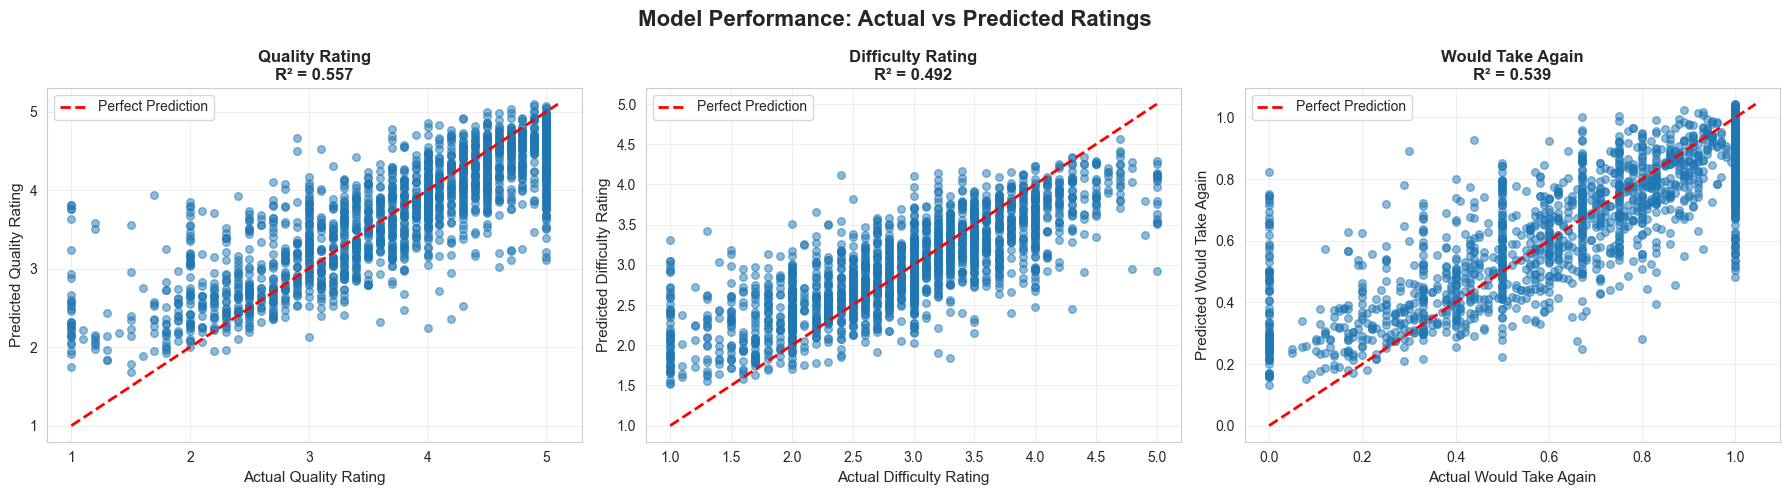

Saved: prediction_error_distribution.png


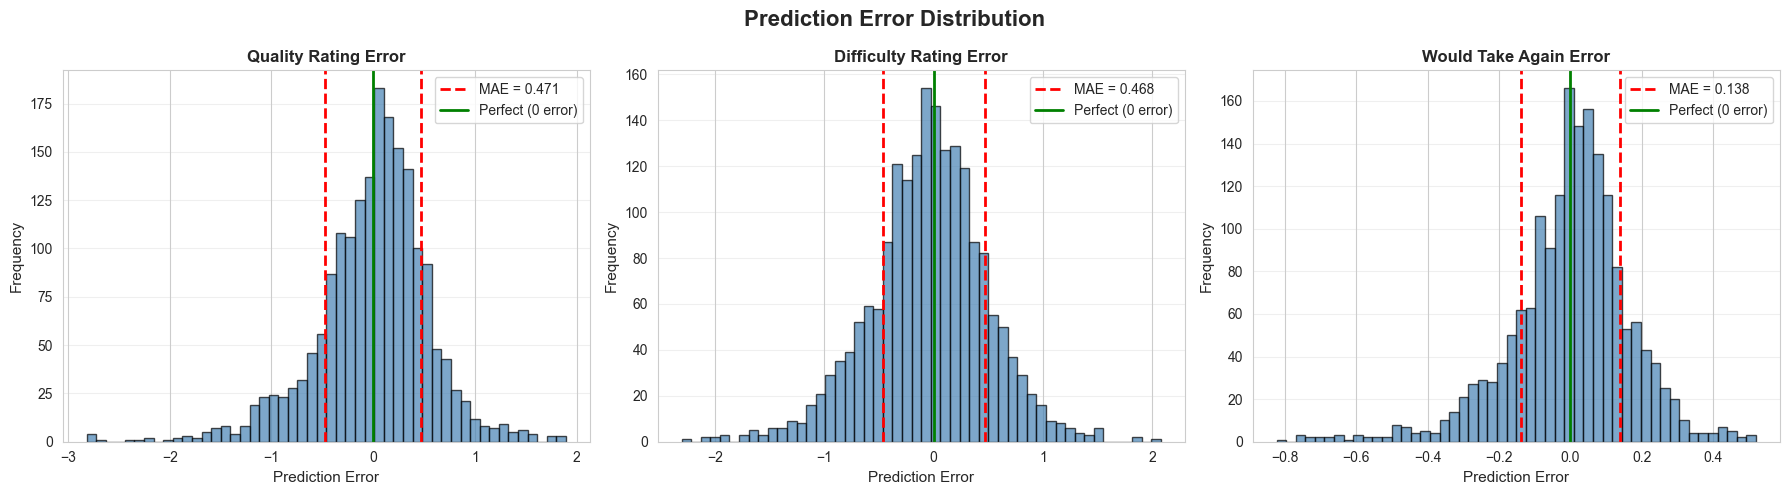

Saved: feature_importance.png


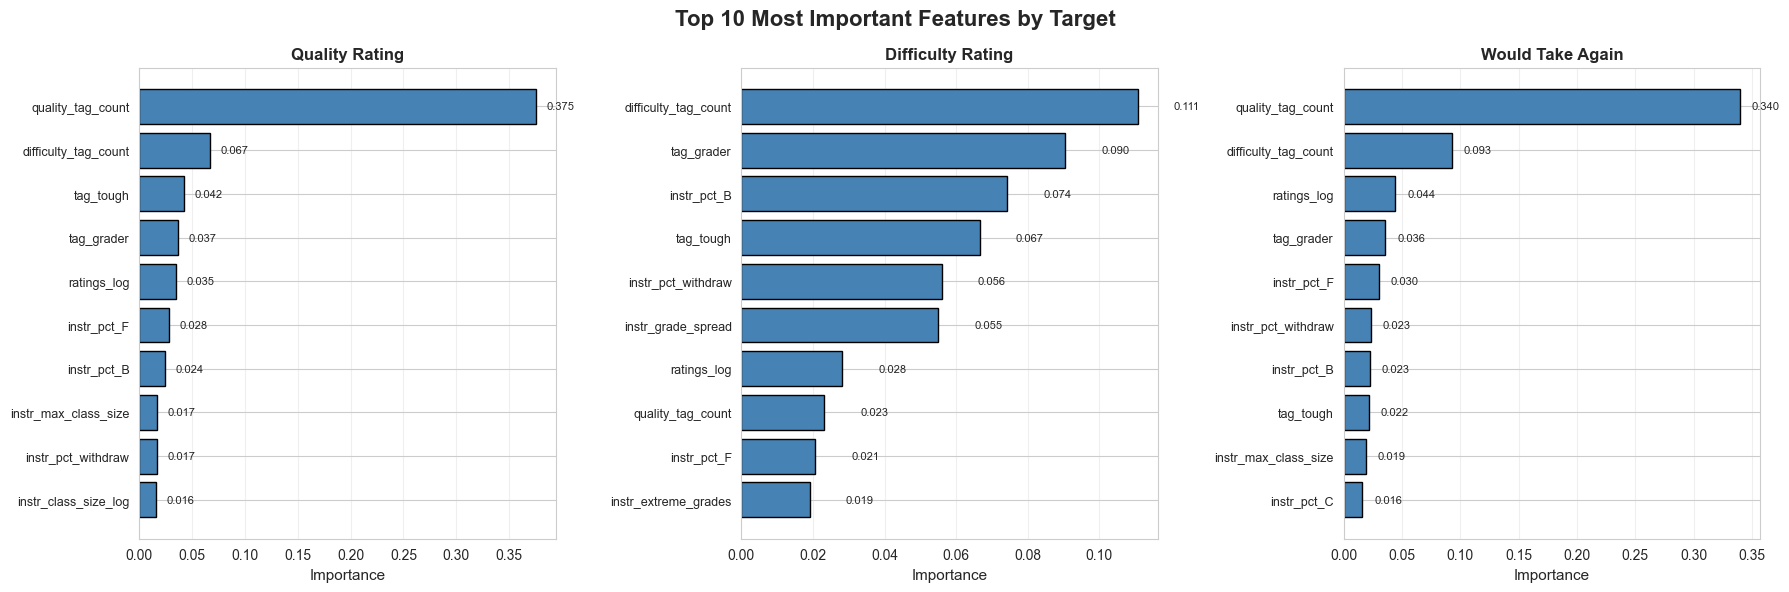

Saved: quality_vs_difficulty.png


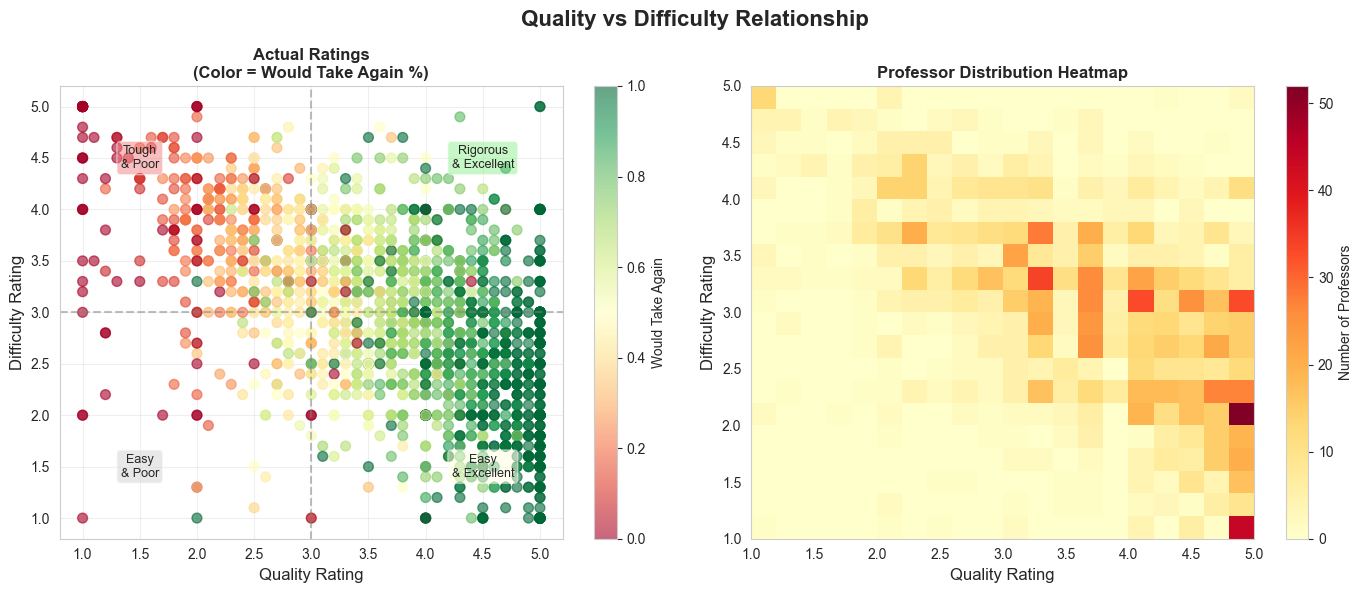

C:\Users\EMW81\AppData\Local\Temp\ipykernel_6612\4218267025.py:239: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  r2_by_bin = viz_df.groupby('ratings_bin').apply(
C:\Users\EMW81\AppData\Local\Temp\ipykernel_6612\4218267025.py:239: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r2_by_bin = viz_df.groupby('ratings_bin').apply(


Saved: ratings_count_impact.png


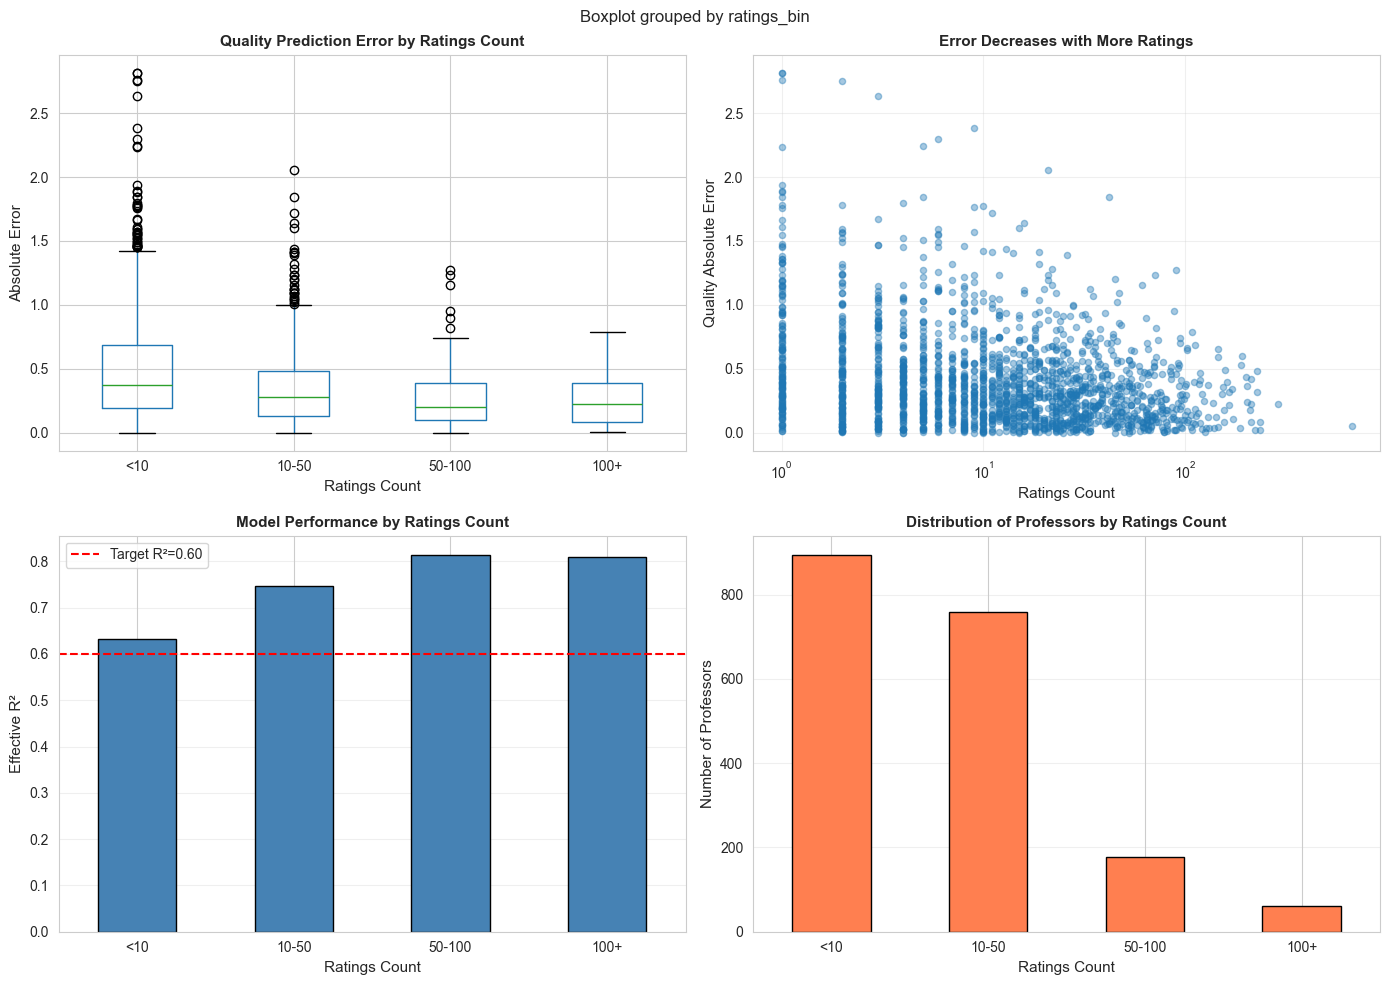

Saved: tag_analysis.png


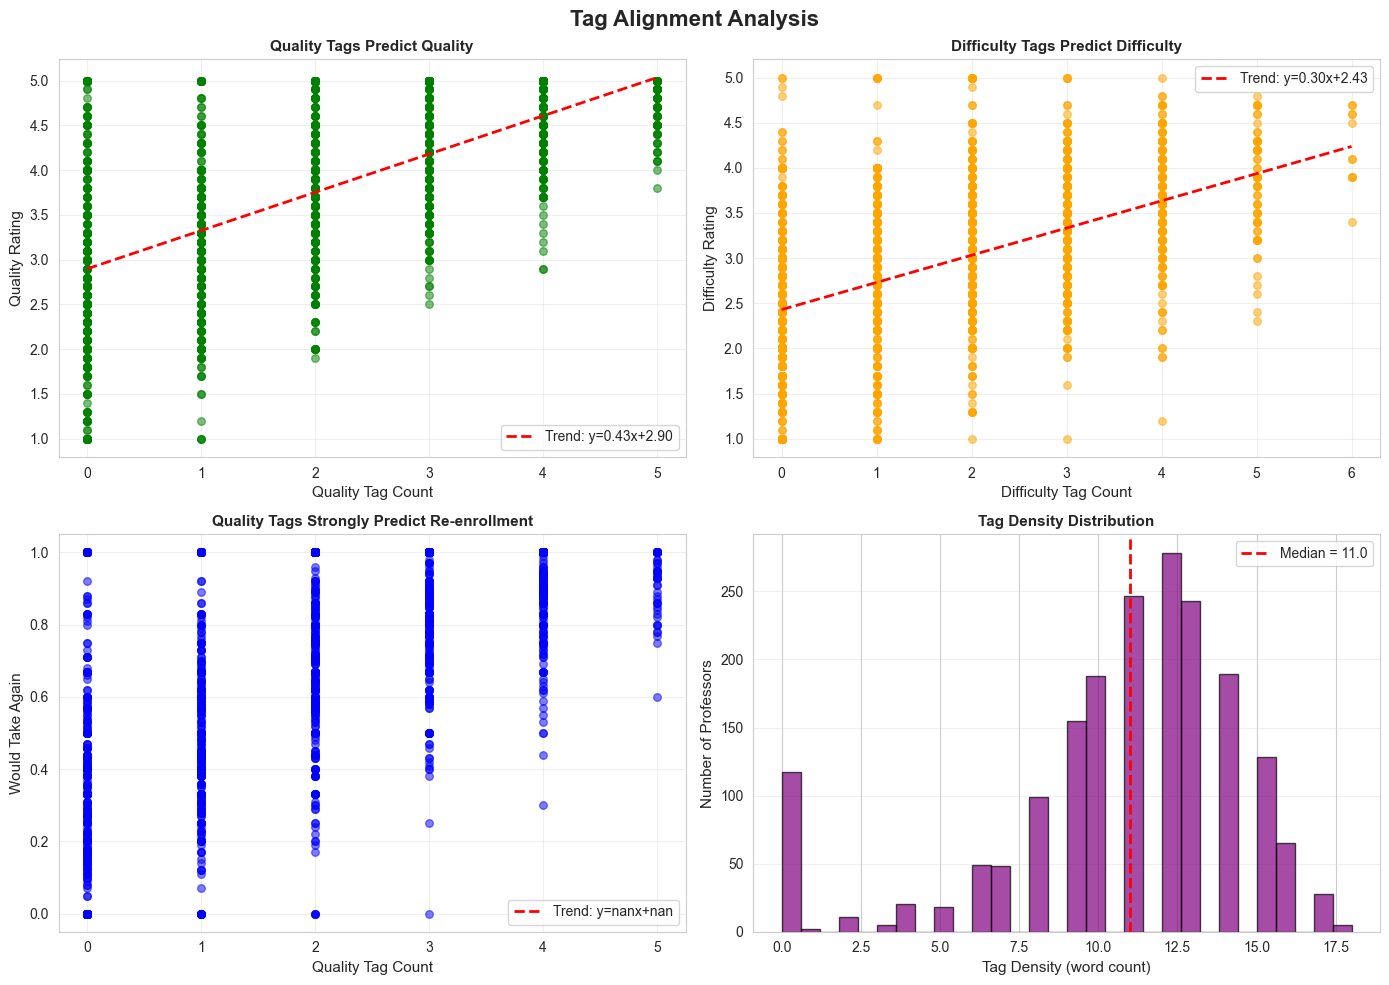


All visualizations complete


In [253]:
# create graphics for detailed reporting
create_visualizations(final_df, eval_results, pipeline, numeric, categorical, text_col)